# 1.라이브러리 및 데이터 


pandas 1.1.5

numpy 1.19.5

matplotlib 3.2.2

seaborn 0.11.2

개발환경 colab 


In [ ]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import math
import copy
from google.colab import drive
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)

In [ ]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cus = pd.read_csv("/content/drive/MyDrive/open/cus_info.csv") #고객 정보 
iem = pd.read_csv("/content/drive/MyDrive/open/iem_info_20210902.csv") # 종목 종보 
hist = pd.read_csv("/content/drive/MyDrive/open/stk_bnc_hist.csv") # 국내 주식 잔고 수량
train = pd.read_csv("/content/drive/MyDrive/open/stk_hld_train.csv") #학습 데이터
test = pd.read_csv("/content/drive/MyDrive/open/stk_hld_test.csv")  #테스트 데이터
submission = pd.read_csv("/content/drive/MyDrive/open/sample_submission.csv")

# (외부 데이터) 주식 데이터를 가져오는 api pykrx를 통해 개장일을 구별

In [ ]:
pip install pykrx

In [ ]:
from pykrx import stock
def TString(open_date):
  date_time_obj = open_date.strftime("%Y%m%d")
  return date_time_obj
dd = stock.get_market_ohlcv_by_date('20160101', '20201230', "005930")
a=dd.index.tolist()
dayc2=(list(map(TString,a)))
dayc2=dict(zip(range(len(dayc2)),dayc2 ))
ad=list(dayc2.values())
dayc=(list(map(TString,a)))
dayc=dict(zip(dayc, range(len(dayc))))

# 2. 데이터 전처리

In [ ]:
#id별 평균 hold_d를 past_d로 생성 
#종목별 평균 hold_d를 past_d2로 생성 
id_mean = train.groupby(["act_id"])
id_mean=id_mean.mean()["hold_d"]

train=pd.merge(left = train , right = id_mean, how = "left", on = "act_id")
train.rename(columns={"hold_d_x":"hold_d","hold_d_y":"past_d"},inplace=True)
test=pd.merge(left = test , right = id_mean, how = "left", on = "act_id")
test.rename(columns={"hold_d_x":"hold_d","hold_d_y":"past_d"},inplace=True)

id_mean2 = train.groupby(["iem_cd"])
id_mean2=id_mean2.mean()["hold_d"]

train=pd.merge(left = train , right = id_mean2, how = "left", on = "iem_cd")
train.rename(columns={"hold_d_x":"hold_d","hold_d_y":"past_d2"},inplace=True)
test=pd.merge(left = test , right = id_mean2, how = "left", on = "iem_cd")
test.rename(columns={"hold_d_x":"hold_d","hold_d_y":"past_d2"},inplace=True)


In [ ]:
#hist_d2에 같은id로 같은 종목을 이전에 구매한 보유기간을 생성
#total_hist에 같은id로 같은 종목의 총 보유기간 생성
#past_dic에 전부 판매한 횟수 생성
hist["hist_d2"]=0
dic=hist["hist_d2"].to_dict() 
total_hist={}
past_dic={}
#hist에 있는 모든 거래내역에 과거 보유기간을 추가했다 
#갖고있는 종목을 모두 팔고 다시 구매하면 과거 보유기간은 0으로  초기화 
total_hist=hist["hist_d2"].to_dict() #총 보유기간
past_dic=hist["hist_d2"].to_dict() #다 판매한 횟수
hist1=hist.groupby(["act_id","iem_cd"])
for name, group in hist1:
  group=group.sort_values(by=["bse_dt"])
  group_id=group.index
  day_count=-1
  day_count2=0
  total_count=0
  recent_zeroday=0
  pa=0
  for i in range(len(group)):
    if day_count==-1:  
      past_dic[group_id[i]]=pa
      total_hist[group_id[i]]=total_count
      dic[group_id[i]]=day_count2
      day_count+=1
      continue
    start = str(group.loc[group_id[recent_zeroday],"bse_dt"])
    end=str(group.loc[group_id[i],"bse_dt"])
    day_count=dayc[end]-dayc[start]
    dic[group_id[i]]=day_count2
    past_dic[group_id[i]]=pa
    total_hist[group_id[i]]=total_count
    if group.loc[group_id[i],"bnc_qty"]==0:
      pa+=1
      recent_zeroday=i
      total_count+=day_count
      day_count2=day_count
      day_count=-1

 
seri=pd.Series(dic)
seri2=pd.Series(total_hist)
seri3=pd.Series(past_dic)
hist["hist_d2"]=seri
hist["hist_d2"]=hist["hist_d2"].apply(float)
hist["total_hist"]=seri2
hist["total_hist"]=hist["total_hist"].apply(float)
hist["past_dic"]=seri3
hist["past_dic"]=hist["past_dic"].apply(float)

In [ ]:
# merge로 feature을 늘리고 종목이름과 id를 라벨 인코딩 
train_data1 = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data1 = pd.merge(train_data1, iem, how = "left", on = ["iem_cd"])
test_data1 = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data1 = pd.merge(test_data1, iem, how = "left", on = ["iem_cd"])

hist["stk_p"] = hist["tot_aet_amt"] / hist["bnc_qty"]
hist = hist.fillna(0)

train_data1 = pd.merge(train_data1, hist, how = "left", on = ["act_id", "iem_cd"])
train_data1 = train_data1[(train_data1["byn_dt"] == train_data1["bse_dt"])]
train_data1.reset_index(drop = True, inplace = True)

test_data1 = pd.merge(test_data1, hist, how = "left", on = ["act_id", "iem_cd"])
test_data1 = test_data1[(test_data1["byn_dt"] == test_data1["bse_dt"])]
test_data1.reset_index(drop = True, inplace = True)

train_data1 = train_data1.drop([ "iem_cd", "bse_dt"], axis = 1)
test_data1 = test_data1.drop([ "iem_cd", "submit_id", "hold_d", "bse_dt"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data1["iem_krl_nm"] = L_encoder.transform(train_data1["iem_krl_nm"])
test_data1["iem_krl_nm"] = L_encoder.transform(test_data1["iem_krl_nm"])
#   
L_encoder1 = LabelEncoder()
L_encoder1.fit(hist["act_id"])
train_data1["act_id"] = L_encoder1.transform(train_data1["act_id"])
test_data1["act_id"] = L_encoder1.transform(test_data1["act_id"])
train_data1.reset_index(drop = True, inplace=True)

In [ ]:
# 학습 데이터와 테스트 데이터를 구분하기 위한 변수 생성
train_data1['cue'] = 0
test_data1['cue'] = 1

In [ ]:
#test 데이터에는 있고 train 데이터에는 없는 hist_d 구하기 
#20200601(start_sell)이전에 구매하고  20200601~20201230(end_sell) 사이에 판 종목들을 따로 골라내고 여기서 날짜를 하루씩 줄여가며 포함되는 train데이터의 양을 증가시킨다


# dayc함수에 날짜를 넣으면 2016년0102부터 그날 사이 개장일을 출력 
#hist_d는 dayc(구매한 날짜)+hold_d를 통해 판매 날짜를 알아낸다
train_data2= train_data1.copy()
day_index = train_data2.query('byn_dt<=20200601')
day_index["sell_day"]=day_index["byn_dt"].apply(str)
day_index["sell_day"]=day_index["sell_day"].apply(lambda x: dayc[x])
day_index["sell_day"]=day_index["sell_day"]+day_index["hold_d"]
day_index["sell_day"]=day_index["sell_day"].apply(lambda x: int(dayc2[x]))

#hist_d는 dayc[start_sell]- dayc[구매한날짜]/dayc[start_sell]로 구한다 
day_index=day_index.query("(sell_day>=20200601)&(sell_day<=20201230)")
id1=day_index.index
train_data2.drop(train_data2.index[id1],inplace=True)
train_data2=train_data2.reset_index(drop = True)
day_index["hist_d"]= day_index["byn_dt"].apply(str)
day_index["hist_d"]= dayc["20200601"]-day_index["hist_d"].apply(lambda x: dayc[x]-1)
day_index["hist_d"]= day_index["hist_d"]/dayc["20200601"]
day_index["hold_d"]= day_index["hold_d"]/dayc["20201230"]
day_index=day_index.reset_index(drop = True)

#20200601(start_sell)이전에 구매하고  20200601~20201230(end_sell) 사이에 판 종목들을 따로 골라내고 여기서 날짜를 하루씩 줄여가며 포함되는 train데이터의 양을 증가시킨다
# 모든 train 데이터에 hist를 구하면 dayc[start_sell]- dayc[구매한날짜]/dayc[start_sell]에서  dayc[start_sell]값이 너무 작아져 비율이 망가지기 때문에 적당한 기간만 구한다 
start_sell = ad[754:-147]
end_sell=ad[900:-1]
for i in range(len(start_sell)):
  #판매한날 sell_day
  day_index2 = train_data2.query('byn_dt<={0}'.format(int(start_sell[i])))
  day_index2["sell_day"]=day_index2["byn_dt"].apply(str)
  day_index2["sell_day"]=day_index2["sell_day"].apply(lambda x: dayc[x])
  day_index2["sell_day"]=day_index2["sell_day"]+day_index2["hold_d"]
  day_index2["sell_day"]=day_index2["sell_day"].apply(lambda x: int(dayc2[x]))
  #hist를 구하고 hist/hold 비율을 구함 
  day_index2=day_index2.query("(sell_day>={0})&(sell_day<={1})".format(int(start_sell[i]),int(end_sell[i])))
  id2=day_index2.index
  train_data2.drop(train_data2.index[id2],inplace=True)
  train_data2=train_data2.reset_index(drop = True)
  day_index2["hist_d"]= day_index2["byn_dt"].apply(str)
  day_index2["hist_d"]= dayc[start_sell[i]]-day_index2["hist_d"].apply(lambda x: dayc[x]-1)

  day_index2["hist_d"]= day_index2["hist_d"]/dayc[start_sell[i]]
  day_index2["hold_d"]= day_index2["hold_d"]/dayc[end_sell[i]]
  day_index2=day_index2.reset_index(drop = True)
  day_index=pd.concat([day_index,day_index2])
day_index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,act_id,byn_dt,hold_d,past_d,past_d2,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,bnc_qty,tot_aet_amt,stk_par_pr,hist_d2,total_hist,past_dic,stk_p,cue,sell_day,hist_d
0,399,20200512,0.017945,30.340426,56.903846,1,9,3,2,2,9,5,5,8,1112,2,2,99,500.0,945000.0,1000.0,0.0,0.0,0.0,1890.0,0,20200611,0.013889
1,399,20200529,0.008157,30.340426,13.586124,1,9,3,2,2,9,5,5,8,228,13,2,99,107.0,882750.0,500.0,0.0,0.0,0.0,8250.0,0,20200612,0.001852
2,7080,20200511,0.067700,112.750000,26.931464,1,6,0,3,2,5,5,6,9,3037,2,2,1,1.0,69400.0,5000.0,0.0,0.0,0.0,69400.0,0,20200904,0.014815
3,7080,20200601,0.025285,112.750000,25.788732,1,6,0,3,2,5,5,6,9,974,10,3,99,25.0,66125.0,1000.0,0.0,0.0,0.0,2645.0,0,20200714,0.000926
4,7080,20200528,0.051387,112.750000,31.118644,1,6,0,3,2,5,5,6,9,1065,10,2,99,35.0,338800.0,500.0,0.0,0.0,0.0,9680.0,0,20200826,0.002778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,3055,20200528,0.000817,6.462963,27.000000,2,7,0,5,2,5,3,3,2,1893,5,3,99,303.0,1733160.0,500.0,0.0,0.0,0.0,5720.0,0,20200529,0.000928
541,7195,20200528,0.000817,2.653700,21.870968,2,7,99,4,2,8,3,3,13,1860,10,3,99,400.0,3432000.0,500.0,0.0,0.0,0.0,8580.0,0,20200529,0.000928
542,4756,20200528,0.000817,19.381579,15.847244,1,6,99,2,2,5,5,2,13,1878,10,2,99,3.0,106200.0,500.0,0.0,0.0,0.0,35400.0,0,20200529,0.000928
543,7490,20200528,0.000817,10.066667,14.952727,2,7,99,3,2,8,4,2,10,843,10,2,99,760.0,2994400.0,100.0,1.0,1.0,1.0,3940.0,0,20200529,0.000928


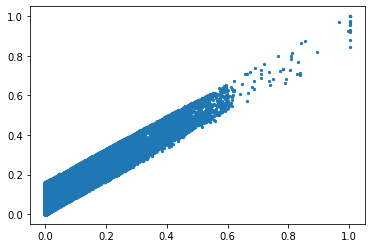

In [ ]:
plt.scatter(day_index["hist_d"], day_index["hold_d"], s=5)

In [ ]:
# 학습 데이터와 테스트 데이터 통합
df = pd.concat([day_index, test_data1], axis=0)
df.reset_index(drop = True, inplace=True)
df.drop(["sell_day"], axis = 1, inplace = True)

In [ ]:

#각 피쳐의 평균 hold_d값들을 새로운 피쳐로 저장해준다 

#요일 체크 
def day(d):
  d=str(d)
  wk= datetime.date(int(d[0:4]),int(d[4:6]),int(d[6:8])).weekday()
  return wk
df["day"]=df["byn_dt"].transform(day)
df.drop(["byn_dt"], axis = 1, inplace = True)

# 요일별 hold_d 평균
def week_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['weekdaymean'] = 1
    index0 = df.query('day==0').index
    index1 = df.query('day==1').index
    index2 = df.query('day==2').index
    index3 = df.query('day==3').index
    index4 = df.query('day==4').index
    df.iloc[index0,-1] = train_data.query('day==0')['hold_d'].mean()
    df.iloc[index1,-1] = train_data.query('day==1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('day==2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('day==3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('day==4')['hold_d'].mean()
    return df
df = week_mean()

# 종목 업종에 따른 hold_d 평균
def sector_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['btp_cfc_cd_mean'] = 1
    index1 = df.query('btp_cfc_cd == 1').index
    index2 = df.query('btp_cfc_cd == 2').index
    index3 = df.query('btp_cfc_cd == 3').index
    index4 = df.query('btp_cfc_cd == 4').index
    index5 = df.query('btp_cfc_cd == 5').index
    index6 = df.query('btp_cfc_cd == 6').index
    index7 = df.query('btp_cfc_cd == 7').index
    index8 = df.query('btp_cfc_cd == 8').index
    index9 = df.query('btp_cfc_cd == 9').index
    index10 = df.query('btp_cfc_cd == 10').index
    index11 = df.query('btp_cfc_cd == 11').index
    index12 = df.query('btp_cfc_cd == 12').index
    index13 = df.query('btp_cfc_cd == 13').index
    index14 = df.query('btp_cfc_cd == 14').index
    df.iloc[index1,-1] = train_data.query('btp_cfc_cd == 1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('btp_cfc_cd == 2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('btp_cfc_cd == 3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('btp_cfc_cd == 4')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('btp_cfc_cd == 5')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('btp_cfc_cd == 6')['hold_d'].mean()
    df.iloc[index7,-1] = train_data.query('btp_cfc_cd == 7')['hold_d'].mean()
    df.iloc[index8,-1] = train_data.query('btp_cfc_cd == 8')['hold_d'].mean()
    df.iloc[index9,-1] = train_data.query('btp_cfc_cd == 9')['hold_d'].mean()
    df.iloc[index10,-1] = train_data.query('btp_cfc_cd == 10')['hold_d'].mean()
    df.iloc[index11,-1] = train_data.query('btp_cfc_cd == 11')['hold_d'].mean()
    df.iloc[index12,-1] = train_data.query('btp_cfc_cd == 12')['hold_d'].mean()
    df.iloc[index13,-1] = train_data.query('btp_cfc_cd == 13')['hold_d'].mean()
    df.iloc[index14,-1] = train_data.query('btp_cfc_cd == 14')['hold_d'].mean()
    return df
df = sector_mean()


# 요일별 평균 보유기간를 구하는 함수
def market_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['stk_dit_cd_mean'] = 1
    index0 = df.query('stk_dit_cd==1').index
    index1 = df.query('stk_dit_cd==2').index
    index2 = df.query('stk_dit_cd==99').index
    df.iloc[index0,-1] = train_data.query('stk_dit_cd==1')['hold_d'].mean()
    df.iloc[index1,-1] = train_data.query('stk_dit_cd==2')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('stk_dit_cd==99')['hold_d'].mean()
    return df
df = market_mean()


# 요일별 평균 보유기간를 구하는 함수
def market_cap_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['mkt_pr_tal_scl_tp_cd_mean'] = 1
    index0 = df.query('mkt_pr_tal_scl_tp_cd==1').index
    index1 = df.query('mkt_pr_tal_scl_tp_cd==2').index
    index2 = df.query('mkt_pr_tal_scl_tp_cd==3').index
    index3 = df.query('mkt_pr_tal_scl_tp_cd==99').index
    df.iloc[index0,-1] = train_data.query('mkt_pr_tal_scl_tp_cd==1')['hold_d'].mean()
    df.iloc[index1,-1] = train_data.query('mkt_pr_tal_scl_tp_cd==2')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('mkt_pr_tal_scl_tp_cd==3')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('mkt_pr_tal_scl_tp_cd==99')['hold_d'].mean()
    return df
df = market_cap_mean()

# 성에따른 hold_d 평균
def sex_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['sex_mean'] = 1
    index0 = df.query('sex_dit_cd==1').index
    index1 = df.query('sex_dit_cd==2').index
    df.iloc[index0,-1] = train_data.query('sex_dit_cd==1')['hold_d'].mean()
    df.iloc[index1,-1] = train_data.query('sex_dit_cd==2')['hold_d'].mean()
    return df
df = sex_mean()

# 연령에 따른 hold_d 평균
def age_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['cus_age_stn_cd_mean'] = 1
    index1 = df.query('cus_age_stn_cd == 1').index
    index2 = df.query('cus_age_stn_cd == 2').index
    index3 = df.query('cus_age_stn_cd == 3').index
    index4 = df.query('cus_age_stn_cd == 4').index
    index5 = df.query('cus_age_stn_cd == 5').index
    index6 = df.query('cus_age_stn_cd == 6').index
    index7 = df.query('cus_age_stn_cd == 7').index
    index8 = df.query('cus_age_stn_cd == 8').index
    index9 = df.query('cus_age_stn_cd == 9').index
    df.iloc[index1,-1] = train_data.query('btp_cfc_cd == 1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('btp_cfc_cd == 2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('btp_cfc_cd == 3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('btp_cfc_cd == 4')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('btp_cfc_cd == 5')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('btp_cfc_cd == 6')['hold_d'].mean()
    df.iloc[index7,-1] = train_data.query('btp_cfc_cd == 7')['hold_d'].mean()
    df.iloc[index8,-1] = train_data.query('btp_cfc_cd == 8')['hold_d'].mean()
    df.iloc[index9,-1] = train_data.query('btp_cfc_cd == 9')['hold_d'].mean() 
    return df
df = age_mean()

# 종목 업종에 따른 hold_d 평균
def ivs_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['ivs_icn_cd_mean'] = 1
    index1 = df.query('ivs_icn_cd == 1').index
    index2 = df.query('ivs_icn_cd == 2').index
    index3 = df.query('ivs_icn_cd == 3').index
    index4 = df.query('ivs_icn_cd == 4').index
    index5 = df.query('ivs_icn_cd == 5').index
    index6 = df.query('ivs_icn_cd == 9').index
    index7 = df.query('ivs_icn_cd == 0').index
    index8 = df.query('ivs_icn_cd == 99').index
    df.iloc[index1,-1] = train_data.query('ivs_icn_cd == 1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('ivs_icn_cd == 2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('ivs_icn_cd == 3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('ivs_icn_cd == 4')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('ivs_icn_cd == 5')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('ivs_icn_cd == 9')['hold_d'].mean()
    df.iloc[index7,-1] = train_data.query('ivs_icn_cd == 0')['hold_d'].mean()
    df.iloc[index8,-1] = train_data.query('ivs_icn_cd == 99')['hold_d'].mean() 
    return df
df = ivs_mean()

#자산구간 별 hold_d
def cus_aet_stn_cd_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['cus_aet_stn_cd_mean'] = 1
    index1 = df.query('cus_aet_stn_cd == 1').index
    index2 = df.query('cus_aet_stn_cd == 2').index
    index3 = df.query('cus_aet_stn_cd == 3').index
    index4 = df.query('cus_aet_stn_cd == 4').index
    index5 = df.query('cus_aet_stn_cd == 5').index
    index6 = df.query('cus_aet_stn_cd == 6').index
    df.iloc[index1,-1] = train_data.query('cus_aet_stn_cd == 1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('cus_aet_stn_cd == 2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('cus_aet_stn_cd == 3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('cus_aet_stn_cd == 4')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('cus_aet_stn_cd == 5')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('cus_aet_stn_cd == 6')['hold_d'].mean()
 
    return df
df = cus_aet_stn_cd_mean()

# 주거래상품군에 따른 hold_d 평균
def mrz_pdt_tp_sgm_cd_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['mrz_pdt_tp_sgm_cd_mean'] = 1
    index1 = df.query('mrz_pdt_tp_sgm_cd == 1').index
    index2 = df.query('mrz_pdt_tp_sgm_cd == 2').index
    index3 = df.query('mrz_pdt_tp_sgm_cd == 3').index
    index4 = df.query('mrz_pdt_tp_sgm_cd == 5').index
    index5 = df.query('mrz_pdt_tp_sgm_cd == 6').index
    index6 = df.query('mrz_pdt_tp_sgm_cd == 8').index
    index7 = df.query('mrz_pdt_tp_sgm_cd == 9').index
    index8 = df.query('mrz_pdt_tp_sgm_cd == 10').index
    index9 = df.query('mrz_pdt_tp_sgm_cd == 11').index
    index10 = df.query('mrz_pdt_tp_sgm_cd == 12').index
    index11 = df.query('mrz_pdt_tp_sgm_cd == 15').index
    df.iloc[index1,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 5')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 6')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 8')['hold_d'].mean()
    df.iloc[index7,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 9')['hold_d'].mean()
    df.iloc[index8,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 10')['hold_d'].mean()
    df.iloc[index9,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 11')['hold_d'].mean()
    df.iloc[index10,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 12')['hold_d'].mean()
    df.iloc[index11,-1] = train_data.query('mrz_pdt_tp_sgm_cd == 15')['hold_d'].mean()
    return df
df = mrz_pdt_tp_sgm_cd_mean()

#생활 단계 life stage에 따른 hold_d 평균
def lsg_sgm_cd_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['lsg_sgm_cd_mean'] = 1
    index1 = df.query('lsg_sgm_cd == 2').index
    index2 = df.query('lsg_sgm_cd == 3').index
    index3 = df.query('lsg_sgm_cd == 4').index
    index4 = df.query('lsg_sgm_cd == 5').index
    index5 = df.query('lsg_sgm_cd == 6').index
    index6 = df.query('lsg_sgm_cd == 7').index
    index7 = df.query('lsg_sgm_cd == 8').index
    index8 = df.query('lsg_sgm_cd == 9').index
    df.iloc[index1,-1] = train_data.query('lsg_sgm_cd == 2')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('lsg_sgm_cd == 3')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('lsg_sgm_cd == 4')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('lsg_sgm_cd == 5')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('lsg_sgm_cd == 6')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('lsg_sgm_cd == 7')['hold_d'].mean()
    df.iloc[index7,-1] = train_data.query('lsg_sgm_cd == 8')['hold_d'].mean()
    df.iloc[index8,-1] = train_data.query('lsg_sgm_cd == 9')['hold_d'].mean() 
    return df
df = lsg_sgm_cd_mean()

#서비스등급 별 hold_d
def tco_cus_grd_cd_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['tco_cus_grd_cd_mean'] = 1
    index1 = df.query('tco_cus_grd_cd == 1').index
    index2 = df.query('tco_cus_grd_cd == 2').index
    index3 = df.query('tco_cus_grd_cd == 3').index
    index4 = df.query('tco_cus_grd_cd == 4').index
    index5 = df.query('tco_cus_grd_cd == 5').index
    index6 = df.query('tco_cus_grd_cd == 9').index
    df.iloc[index1,-1] = train_data.query('tco_cus_grd_cd == 1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('tco_cus_grd_cd == 2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('tco_cus_grd_cd == 3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('tco_cus_grd_cd == 4')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('tco_cus_grd_cd == 5')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('tco_cus_grd_cd == 9')['hold_d'].mean()
    return df
df = tco_cus_grd_cd_mean()

#총 투자기간 별 hold_d
def tot_ivs_te_sgm_cd_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['tot_ivs_te_sgm_cd_mean'] = 1
    index1 = df.query('tot_ivs_te_sgm_cd == 1').index
    index2 = df.query('tot_ivs_te_sgm_cd == 2').index
    index3 = df.query('tot_ivs_te_sgm_cd == 3').index
    index4 = df.query('tot_ivs_te_sgm_cd == 4').index
    index5 = df.query('tot_ivs_te_sgm_cd == 5').index
    index6 = df.query('tot_ivs_te_sgm_cd == 6').index
    df.iloc[index1,-1] = train_data.query('tot_ivs_te_sgm_cd == 1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('tot_ivs_te_sgm_cd == 2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('tot_ivs_te_sgm_cd == 3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('tot_ivs_te_sgm_cd == 4')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('tot_ivs_te_sgm_cd == 5')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('tot_ivs_te_sgm_cd == 6')['hold_d'].mean()
    return df
df = tot_ivs_te_sgm_cd_mean()

# 주거래 업종에 따른 hold_d 평균
def mrz_btp_dit_cd_mean() :
    train_data = df.query('cue==0').reset_index(drop=True)
    df['mrz_btp_dit_cd_mean'] = 1
    index1 = df.query('mrz_btp_dit_cd == 1').index
    index2 = df.query('mrz_btp_dit_cd == 2').index
    index3 = df.query('mrz_btp_dit_cd == 3').index
    index4 = df.query('mrz_btp_dit_cd == 4').index
    index5 = df.query('mrz_btp_dit_cd == 5').index
    index6 = df.query('mrz_btp_dit_cd == 6').index
    index7 = df.query('mrz_btp_dit_cd == 7').index
    index8 = df.query('mrz_btp_dit_cd == 8').index
    index9 = df.query('mrz_btp_dit_cd == 9').index
    index10 = df.query('mrz_btp_dit_cd == 10').index
    index11 = df.query('mrz_btp_dit_cd == 11').index
    index12 = df.query('mrz_btp_dit_cd == 12').index
    index13 = df.query('mrz_btp_dit_cd == 13').index
    index14 = df.query('mrz_btp_dit_cd == 14').index
    index15 = df.query('mrz_btp_dit_cd == 15').index
    index16 = df.query('mrz_btp_dit_cd == 16').index
    df.iloc[index1,-1] = train_data.query('mrz_btp_dit_cd == 1')['hold_d'].mean()
    df.iloc[index2,-1] = train_data.query('mrz_btp_dit_cd == 2')['hold_d'].mean()
    df.iloc[index3,-1] = train_data.query('mrz_btp_dit_cd == 3')['hold_d'].mean()
    df.iloc[index4,-1] = train_data.query('mrz_btp_dit_cd == 4')['hold_d'].mean()
    df.iloc[index5,-1] = train_data.query('mrz_btp_dit_cd == 5')['hold_d'].mean()
    df.iloc[index6,-1] = train_data.query('mrz_btp_dit_cd == 6')['hold_d'].mean()
    df.iloc[index7,-1] = train_data.query('mrz_btp_dit_cd == 7')['hold_d'].mean()
    df.iloc[index8,-1] = train_data.query('mrz_btp_dit_cd == 8')['hold_d'].mean()
    df.iloc[index9,-1] = train_data.query('mrz_btp_dit_cd == 9')['hold_d'].mean()
    df.iloc[index10,-1] = train_data.query('mrz_btp_dit_cd == 10')['hold_d'].mean()
    df.iloc[index11,-1] = train_data.query('mrz_btp_dit_cd == 11')['hold_d'].mean()
    df.iloc[index12,-1] = train_data.query('mrz_btp_dit_cd == 12')['hold_d'].mean()
    df.iloc[index13,-1] = train_data.query('mrz_btp_dit_cd == 13')['hold_d'].mean()
    df.iloc[index14,-1] = train_data.query('mrz_btp_dit_cd == 14')['hold_d'].mean()
    df.iloc[index15,-1] = train_data.query('mrz_btp_dit_cd == 15')['hold_d'].mean()
    df.iloc[index16,-1] = train_data.query('mrz_btp_dit_cd == 16')['hold_d'].mean()
    
    return df
df = mrz_btp_dit_cd_mean()

# 3. 피쳐 선정

피쳐를 하나씩 추가하며 rmse가 오르면 추가하고 내려가면 삭제한다
2시간 소요

In [ ]:
#피쳐를 두개만 이용해서 시작해 하나씩 추가하며 rmse가 오르면 추가하고 오르지않으면 추가하지않는다 
df2= df.copy()
dc=df2.columns.tolist()[:]
df_best = ["hist_d","cus_age_stn_cd"]
#['hist_d', 'cus_age_stn_cd', 'cus_aet_stn_cd', 'tco_cus_grd_cd', 'btp_cfc_cd', 'bnc_qty', 'day', 'weekdaymean'] =1.423
best_rmse =0.028  #1.603
dc.remove('cue')
dc.remove("hold_d")
for i in df_best:
  dc.remove(i)
# dc=dc[6:]
X_train = df2.query("cue==0").drop(['cue', 'hold_d'], axis='columns')
# 테스트 데이터
X_test = df2.query("cue==1").drop(['cue', 'hold_d'], axis='columns')
# 타깃 변수
y_train = df2.query("cue==0")['hold_d']
for i in dc:
  df_best.append(i)
  X_train1 =X_train[df_best]
  X_test1 =X_test[df_best]

  model = LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31,
                          random_state=1217)
  # cv=5인 교차 검증
  scores = cross_val_score(model, X_train1, y_train, cv=10, n_jobs=-1,
                         scoring = 'neg_mean_squared_error')
  # 성능 확인
  print(df_best)
  print('cross_val_score \n{}'.format(np.sqrt(-scores)))
  print('cross_val_score.mean \n{:.5f}'.format(np.sqrt(-scores.mean())))
  
  if np.sqrt(-scores.mean()) <= best_rmse:
    best_rmse= np.sqrt(-scores.mean())
    print("{0}가 추가되어 정확도가 같거나 올랐습니다".format(i))
  else:
    
    df_best.remove(i)
    print("{0}가 추가되어 정확도가 떨어졌습니다".format(i))


['hist_d', 'cus_age_stn_cd', 'act_id']
cross_val_score 
[0.04789789 0.03587195 0.03329273 0.03501778 0.02932378 0.01986002
 0.01529617 0.00932024 0.00544405 0.006847  ]
cross_val_score.mean 
0.02751
act_id가 추가되어 정확도가 같거나 올랐습니다
['hist_d', 'cus_age_stn_cd', 'act_id', 'past_d']
cross_val_score 
[0.04753234 0.03462616 0.03144908 0.03345497 0.02817564 0.0184895
 0.01451825 0.00883732 0.00522011 0.00685321]
cross_val_score.mean 
0.02658
past_d가 추가되어 정확도가 같거나 올랐습니다
['hist_d', 'cus_age_stn_cd', 'act_id', 'past_d', 'past_d2']
cross_val_score 
[0.04701006 0.03473688 0.03133729 0.03342714 0.02813938 0.01847105
 0.01443624 0.00873288 0.00521037 0.0068056 ]
cross_val_score.mean 
0.02647
past_d2가 추가되어 정확도가 같거나 올랐습니다
['hist_d', 'cus_age_stn_cd', 'act_id', 'past_d', 'past_d2', 'sex_dit_cd']
cross_val_score 
[0.04690973 0.03465968 0.03131745 0.03347362 0.02813018 0.01847488
 0.0144285  0.0087246  0.00521406 0.00677146]
cross_val_score.mean 
0.02644
sex_dit_cd가 추가되어 정확도가 같거나 올랐습니다
['hist_d', 'cus_age_st

#4.학습

train 데이터의 hist_d 항목을 추가하기 위해서 기존 data에서 많은 양을 제외 시켰다

best=['hist_d', "cue",'cus_age_stn_cd', 'act_id', 'past_d', 'past_d2', 'sex_dit_cd', 'lsg_sgm_cd', 'iem_krl_nm', 'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd', 'tot_aet_amt', 'stk_par_pr', 'btp_cfc_cd_mean', 'sex_mean','hist_d2']
만 학습에 이용 


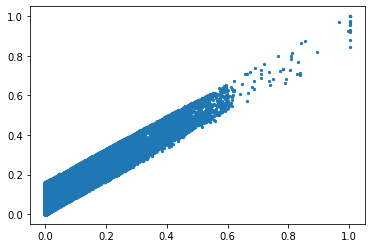

In [ ]:
plt.scatter(df["hist_d"], df["hold_d"], s=5)
plt.show()

In [ ]:
#test 데이터에 dayc["20201230"]를 나누어서 비율로 바꿔 학습
best=['hist_d', "cue",'cus_age_stn_cd', 'act_id', 'past_d', 'past_d2', 'sex_dit_cd', 'lsg_sgm_cd', 'iem_krl_nm', 'btp_cfc_cd', 'mkt_pr_tal_scl_tp_cd', 'tot_aet_amt', 'stk_par_pr', 'btp_cfc_cd_mean', 'sex_mean','hist_d2']
X_train = df[best].query("cue==0").drop(['cue'], axis='columns')
# 테스트 데이터
X_test = df[best].query("cue==1").drop(['cue'], axis='columns')
X_test["hist_d"]=X_test["hist_d"]/dayc["20201230"]
# 타깃 변수
y_train = df.query("cue==0")['hold_d']


lgbm = lgb.LGBMRegressor(objective= "regression",
                          max_depth= 5,
                          n_estimators= 2000,
                          learning_rate= 0.01,
                          num_leaves = 31,
                         random_state=1217)
# 모델 학습
lgbm.fit(X_train, y_train)
# 예측값 생성
y_test1 = lgbm.predict(X_test)



In [ ]:
#예측한 test 데이터의 hold_d값에 dayc["20210730"]를 곱해 비율에서 보유기간으로 바꿔줌 
dayx = stock.get_market_ohlcv_by_date('20160101', '20210730', "005930")
a=dayx.index.tolist()
dayc=(list(map(TString,a)))
dayc=dict(zip(dayc, range(len(dayc))))
y_test= abs(y_test1)*dayc["20210730"]
y_test=np.ceil(y_test)


In [ ]:
#test 데이터의 hist_d와 hold_d 차이가 0이하 146이상인 경우를 뽑아 변경해줌 
#차이가 146이상인경우 120으로 0이하 인경우 73으로 변경(public 점수를 통해 값을 정함)
X_test["hold_d"]=y_test
X_test["hist_d"]=X_test["hist_d"]*1226
X_test["minus"]=X_test["hold_d"]-X_test["hist_d"]
X_test=X_test.reset_index(drop = True)
kk=X_test.query("minus>146").index
kk2=X_test.query("minus<1").index
X_test.iloc[kk,-1]=120
X_test.iloc[kk2,-1]=73
X_test["hold_d"]=X_test["hist_d"]+X_test["minus"]
submission["hold_d"] = X_test["hold_d"]
submission.to_csv("dacon_baseline.csv", index = False)

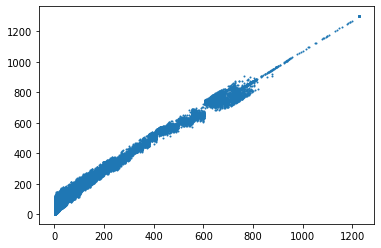

In [ ]:
plt.scatter(X_test["hist_d"], X_test["hold_d"], s=1)
plt.show()